# CODE 

## Import Main Libraries

In [1]:
import numpy as np      
import pandas as pd     
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
from sklearn import metrics

tf.keras.backend.clear_session()  

## Data Loading and Directory Setup

In [2]:
# Define the main path and subdirectories for training, validation, and test sets
main_path = '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

# Print subfolder names to verify structure (each should contain 'real' and 'fake' folders)
print("Train_dir Subfolders:", os.listdir(train_dir))
print("Valid_dir Subfolders:", os.listdir(valid_dir))
print("Test_dir Subfolders:", os.listdir(test_dir))

Train_dir Subfolders: ['fake', 'real']
Valid_dir Subfolders: ['fake', 'real']
Test_dir Subfolders: ['fake', 'real']


## Exploratory Data Analysis (EDA)

In [3]:
# Create a dataframe that stores folder names, image paths, and labels
images_df = {
    "folder": [],
    "image_path": [],
    "label": []
}

for folder in os.listdir(main_path):  # Iterate over train, valid, and test folders
    for label in os.listdir(os.path.join(main_path, folder)):  # Iterate over fake and real subfolders
        for img in glob.glob(os.path.join(main_path, folder, label, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
images_df  # View the dataframe

,folder,image_path,label
0,valid,/kaggle/input/deep-learning-project/real_vs_fa...,fake
1,valid,/kaggle/input/deep-learning-project/real_vs_fa...,fake
2,valid,/kaggle/input/deep-learning-project/real_vs_fa...,fake
3,valid,/kaggle/input/deep-learning-project/real_vs_fa...,fake
4,valid,/kaggle/input/deep-learning-project/real_vs_fa...,fake
...,...,...,...
139995,train,/kaggle/input/deep-learning-project/real_vs_fa...,real
139996,train,/kaggle/input/deep-learning-project/real_vs_fa...,real
139997,train,/kaggle/input/deep-learning-project/real_vs_fa...,real
139998,train,/kaggle/input/deep-learning-project/real_vs_fa...,real


## Labels Distribution

In [4]:
# Group images by folder for each label to check distribution
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

print("Real Images Count:\n", real_grouped_df.size())
print("Fake Images Count:\n", fake_grouped_df.size())

Real Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64
Fake Images Count:
 folder
test     10000
train    50000
valid    10000
dtype: int64


## Data Augmentation Setup

In [5]:
# Set up ImageDataGenerators for training (with augmentation) and for validation/testing (rescaling only)
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

## Data Flow Setup for Training, Validation, and Testing

In [6]:
# Create training, validation, and test datasets using flow_from_directory
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

# For test data, disable shuffling to keep predictions aligned with ground truth
test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Helper Function for Visualizing Images

In [7]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title("Fake" if label[i] == 0 else "Real")

## Visualize a Batch of Training Images

In [ ]:
# Get a batch from the training set and visualize
img_batch, lbl_batch = next(train_ds)
plot_images(img_batch, lbl_batch)

## Check Image Scaling and Input Shape

In [9]:
# Check the scaled pixel values
for img, label in train_ds:
    print("Example image values:", img[0])
    print("Example label:", label[0])
    break

# Check the shape of a batch
for img, label in train_ds:
    print("Image batch shape:", img.shape)  # Expected: (batch_size, 256, 256, 3)
    print("Label batch shape:", label.shape)
    break

# Display class indices (mapping labels to numeric values)
print("Class indices:", train_ds.class_indices)

Image batch shape: (64, 256, 256, 3)
Label batch shape: (64,)
Class indices: {'fake': 0, 'real': 1}


## Build the CNN Model Using DenseNet121

In [15]:
# Define input shape
input_shape = (256, 256, 3)

# Build the model using DenseNet121 as the backbone
def get_model(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    densenet = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = tf.keras.Model(densenet.input, output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model_ft = get_model(input_shape)
model_ft.summary()
# tf.keras.utils.plot_model(model_ft, show_shapes=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 262, 262, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

## Define Training Callbacks

In [16]:
# Set up callbacks to save the best model and adjust training as necessary
checkpoint_filepath = "model_cp.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

## Train the DenseNet121 Model

In [17]:
# Train the model with the training and validation datasets
history_ft = model_ft.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744802756.873269     115 service.cc:148] XLA service 0x7cfc580030e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744802756.874131     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744802765.537674     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744802849.870377     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1105s 590ms/step - accuracy: 0.9139 - loss: 0.2079 - val_accuracy: 0.7886 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 605s 386ms/step - accuracy: 0.9799 - loss: 0.0532 - val_accuracy: 0.9377 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 588s 375ms/step - accuracy: 0.9840 - loss: 0.0418 - val_accuracy: 0.9260 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 587s 375ms/step - accuracy: 0.9879 - loss: 0.0343 - val_accuracy: 0.9208 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 598s 381ms/step - accuracy: 0.9894 - loss: 0.0291 - val_accuracy: 0.9646 - val_loss: 0.0938 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 591s 377ms/step - accuracy: 0.9914 - loss: 0.0249 - val_accuracy: 0.9524 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 603s 385ms/step - ac

## Plot Training History

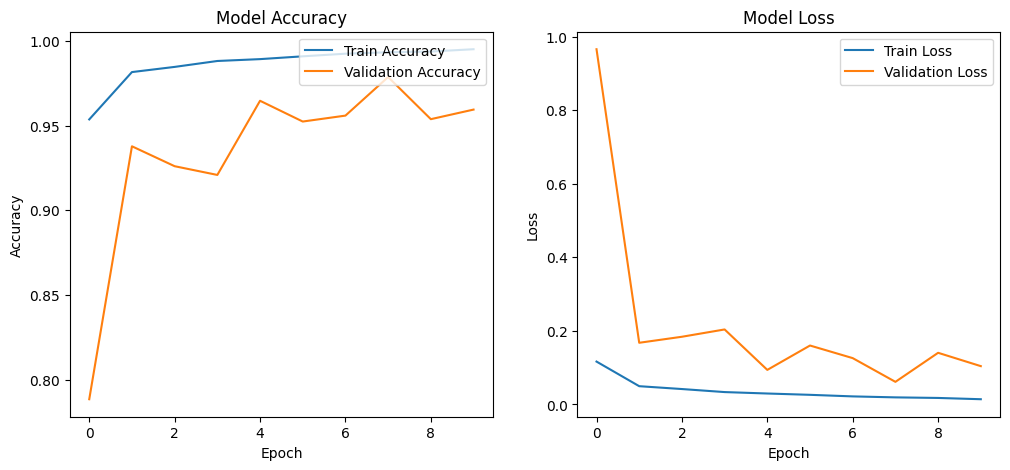

In [18]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Evaluate the Model on the Test Set (Before Restoration)

In [19]:
# Evaluate the model (which may be overfitted) on the test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 558ms/step - accuracy: 0.9736 - loss: 0.0854
Test Loss: 0.060867808759212494
Test Accuracy: 0.980650007724762


## Restore Best Weights and Re-Evaluate

In [20]:
# Create a new model instance and load the best weights saved during training
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')  # Adjust the path as necessary

# Evaluate the restored model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss after restoring best weights:", test_loss)
print("Test Accuracy after restoring best weights:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 738 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.9736 - loss: 0.0854
Test Loss after restoring best weights: 0.060867808759212494
Test Accuracy after restoring best weights: 0.980650007724762


## Qualitative Results: Real Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

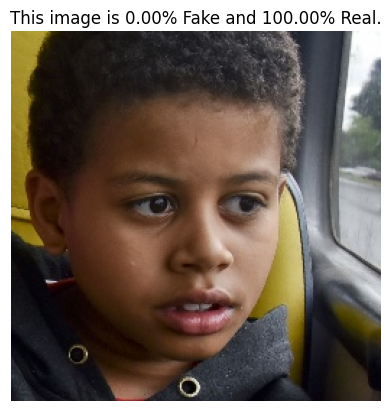

In [21]:
# Load a real image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/real/00343.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


## Qualitative Results: Fake Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Text(0.5, 1.0, 'This image is 99.83% Fake and 0.17% Real.')

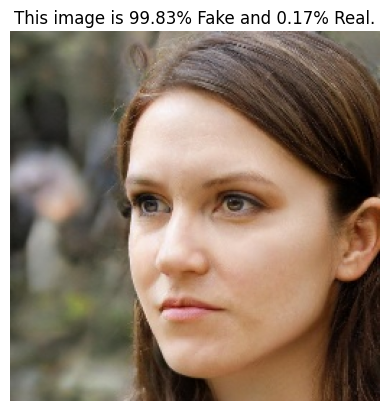

In [22]:
# Load a fake image example and predict
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/deep-learning-project/real_vs_fake/real-vs-fake/test/fake/00V5CZZSSO.jpg',
    target_size=(256, 256, 3)
)
plt.imshow(test_image)
plt.axis('off')

test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image_arr, axis=0)
test_image_arr = test_image_arr / 255.

result = model.predict(test_image_arr)
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

## Quantitative Results: Confusion Matrix and ROC Curve

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 228ms/step


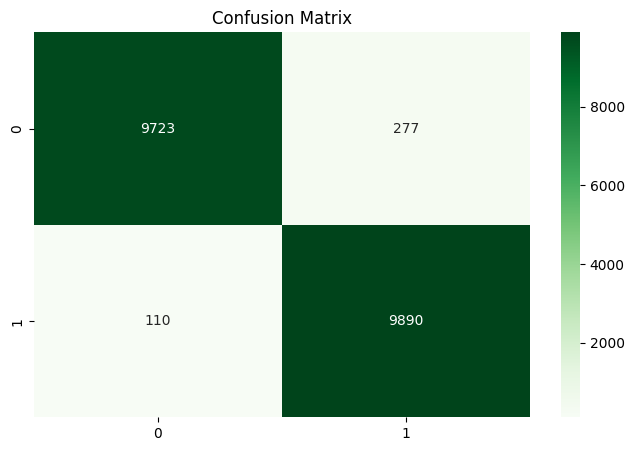

Test Accuracy (using confusion matrix): 0.98065


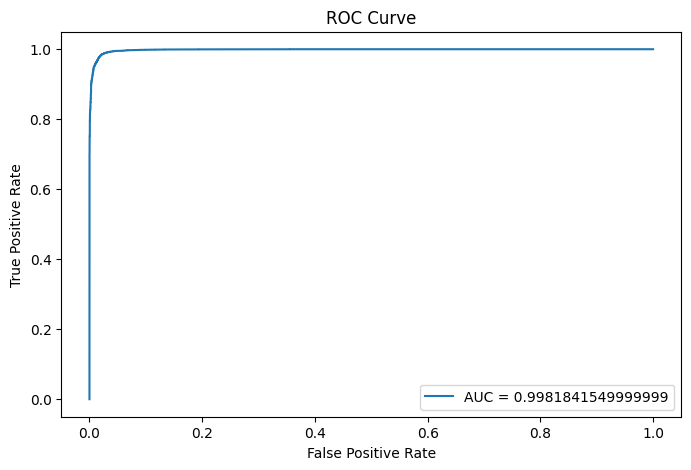

In [23]:
# Generate predictions for the test set
predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()),
            annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.show()

print("Test Accuracy (using confusion matrix):", metrics.accuracy_score(true_labels, predicted_labels.round()))

# Compute and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(true_labels, predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label="AUC = " + str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

## Save Final Model

In [25]:
# Save the final trained model to disk
model.save('deepfake_detection_model.h5')
print("Final model saved successfully!")

Final model saved successfully!
